In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('CarPrice_Assignment (3).csv')

In [ ]:
brands = ['alfa romeo',
          'chevrolet',
          'bmw',
          'audi',
          'dodge',
          'honda',
          'isuzu',
          'jaguar',
          'mazda',
          'buick',
          'mercury',
          'mitsubishi',
          'nissan',
          'peugeot',
          'plymouth',
          'porsche',
          'renault',
          'saab',
          'subaru',
          'toyota',
          'volkswagen',
          'volvo']

In [ ]:
def extract_brand(car_name):
    for brand in brands:
        if car_name.startswith(brand):
            return brand
    return car_name.split()[0]
df['Brand'] = df['CarName'].apply(extract_brand)

In [ ]:
str_to_num = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}
df['cylindernumber'] = df['cylindernumber'].map(str_to_num)

In [ ]:
str_to_num = {
    'two': 2,
    'four': 4,
}
df['doornumber'] = df['doornumber'].map(str_to_num)

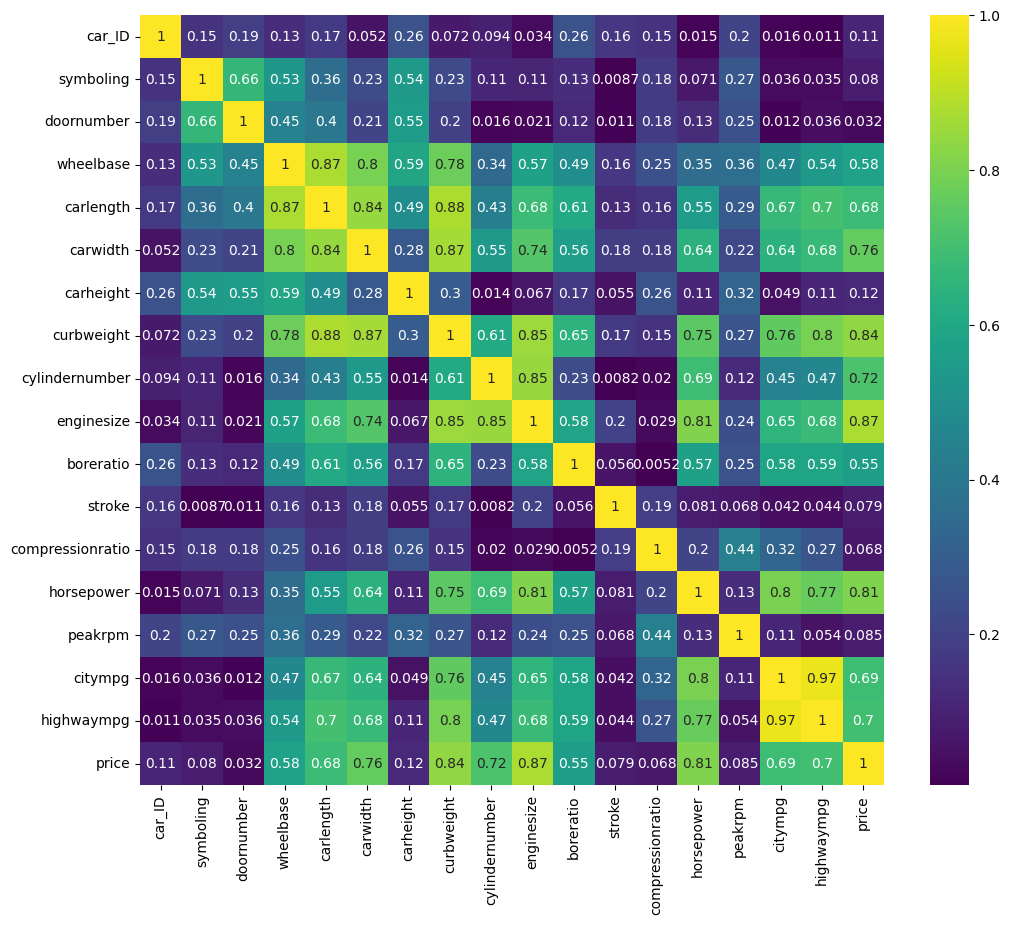

In [ ]:
df_mod = df.select_dtypes(include=[float, int])

plt.figure(figsize = (12, 10))
sns.heatmap(abs(df_mod.corr()), annot = True, cmap="viridis")
plt.show()

In [ ]:
df_modern = df.copy()
df_modern['citympg_highwaympg'] = (df_modern['highwaympg'] + df_modern['citympg'])/2

df_modern = df_modern.drop(['car_ID','CarName','highwaympg','citympg','symboling','doornumber'], axis = 1)

In [ ]:
df_modern.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fueltype            205 non-null    object 
 1   aspiration          205 non-null    object 
 2   carbody             205 non-null    object 
 3   drivewheel          205 non-null    object 
 4   enginelocation      205 non-null    object 
 5   wheelbase           205 non-null    float64
 6   carlength           205 non-null    float64
 7   carwidth            205 non-null    float64
 8   carheight           205 non-null    float64
 9   curbweight          205 non-null    int64  
 10  enginetype          205 non-null    object 
 11  cylindernumber      205 non-null    int64  
 12  enginesize          205 non-null    int64  
 13  fuelsystem          205 non-null    object 
 14  boreratio           205 non-null    float64
 15  stroke              205 non-null    float64
 16  compress

In [ ]:
transformed_dataframe = pd.get_dummies(df_modern, columns = ['fueltype',
                                                      'aspiration',
                                                      'carbody',
                                                      'drivewheel',
                                                      'enginelocation',
                                                      'enginetype',
                                                      'fuelsystem',
                                                      'Brand'],drop_first = True)
transformed_dataframe.shape

(205, 57)

In [ ]:
pip install neptune

In [ ]:
pip install neptune_tensorflow_keras

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00


# **NN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
X_tfdf = transformed_dataframe.drop('price',axis = 1 )
y_tfdf = transformed_dataframe['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X_tfdf, y_tfdf, train_size = 0.7, random_state = 42)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mmc = MinMaxScaler()

X_train = mmc.fit_transform(X_train)
X_test = mmc.transform(X_test)

In [ ]:
import neptune
from neptune_tensorflow_keras import NeptuneCallback
import itertools

**На слоях однинаковое к-во нейронов**

In [ ]:
run = neptune.init_run(
    project="vladislavermakovich/Lesson28",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [32,50, 45],
    'epochs': [50, 100, 350, 500, 400,750],
    'layers': [35, 50, 75, 100, 250, 350, 500]
}


param_combinations = list(itertools.product(
    params['learning_rate'],
    params['batch_size'],
    params['epochs'],
    params['layers']
))

run['parameters'] = params

for lr, batch_size, epochs, layers in param_combinations:
    print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}, layers={layers}")

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layers, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(layers, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(layers, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(10, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(1)
    ])


    model.compile(
        loss=tf.keras.losses.mae,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['mae']
    )


    run['parameters'] = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': epochs, 'layers': layers}


    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')


    model_h = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[neptune_cbk],
        verbose=0
    )
    print(f"Loss train - {model_h.history['loss'][-1]}, Loss val - {model_h.history['val_loss'][-1]}\n")


run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/Lesson28/e/LES-3
Training with lr=0.1, batch_size=32, epochs=50, layers=35
Loss train - 1244.586181640625, Loss val - 1920.218994140625

Training with lr=0.1, batch_size=32, epochs=50, layers=50
Loss train - 1230.0709228515625, Loss val - 1864.0345458984375

Training with lr=0.1, batch_size=32, epochs=50, layers=75
Loss train - 2224.192626953125, Loss val - 2399.70654296875

Training with lr=0.1, batch_size=32, epochs=50, layers=100
Loss train - 1674.6851806640625, Loss val - 2693.707763671875

Training with lr=0.1, batch_size=32, epochs=50, layers=250
Loss train - 1036.53515625, Loss val - 1960.7708740234375

Training with lr=0.1, batch_size=32, epochs=50, layers=350
Loss train - 1016.8872680664062, Loss val - 1922.0963134765625

Training with lr=0.1, batch_size=32, epochs=50, layers=500
Loss train - 1501.100341796875, Loss val - 2553.97119140625

Training with lr=0.1, batch_size=32, e

Training with lr=0.1, batch_size=32, epochs=500, layers=250

Loss train - 825.2963256835938, Loss val - 1506.522460937

**На слоях разное к-во нейронов**

In [ ]:
run = neptune.init_run(
    project="vladislavermakovich/Lesson28",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDdiZjk2My0zYjIyLTRiM2MtYTUzYy0zYWM1NjI4MTNlYjEifQ==",
)

params = {
    'learning_rate': [0.1, 0.15, 0.25, 0.45],
    'batch_size': [32,50],
    'epochs': [50, 100, 350, 500, 750],
    'layers': [ 50, 75, 100, 250, 350, 500]
}


param_combinations = list(itertools.product(
    params['learning_rate'],
    params['batch_size'],
    params['epochs'],
    params['layers']
))

run['parameters'] = params

for lr, batch_size, epochs, layers in param_combinations:
    print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}, layers={layers}")

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(layers, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(layers//4, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(layers//2, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(layers*2, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(10, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(1)
    ])


    model.compile(
        loss=tf.keras.losses.mae,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['mae']
    )


    run['parameters'] = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': epochs, 'layers': layers}


    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')


    model_h = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[neptune_cbk],
        verbose=0
    )
    print(f"Loss train - {model_h.history['loss'][-1]}, Loss val - {model_h.history['val_loss'][-1]}\n")


run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/vladislavermakovich/Lesson28/e/LES-4
Training with lr=0.1, batch_size=32, epochs=50, layers=50
Loss train - 2087.042236328125, Loss val - 1957.9656982421875

Training with lr=0.1, batch_size=32, epochs=50, layers=75
Loss train - 1417.7591552734375, Loss val - 2129.32763671875

Training with lr=0.1, batch_size=32, epochs=50, layers=100
Loss train - 1764.1265869140625, Loss val - 1915.31591796875

Training with lr=0.1, batch_size=32, epochs=50, layers=250
Loss train - 1028.61181640625, Loss val - 1917.718505859375

Training with lr=0.1, batch_size=32, epochs=50, layers=350
Loss train - 1492.53173828125, Loss val - 1720.3656005859375

Training with lr=0.1, batch_size=32, epochs=50, layers=500
Loss train - 1051.0616455078125, Loss val - 2114.573974609375

Training with lr=0.1, batch_size=32, epochs=100, layers=50
Loss train - 1026.34814453125, Loss val - 2090.290771484375

Training with lr=0.1, batch_size=32, 

Training with lr=0.1, batch_size=32, epochs=750, layers=250

Loss train - 577.0170288085938, Loss val - 1378.920654296875

Training with lr=0.15, batch_size=32, epochs=500, layers=500

Loss train - 1208.0657958984375, Loss val - 1443.211669921875

**Через оптуну, одинаковое к-во нейронов на слоях, эпох 350, батч - 32**

In [ ]:
def objective(trial):

    num_units = trial.suggest_int('num_units', 57, 512, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)


    model = Sequential([
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1)
    ])


    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)


    history = model.fit(X_train, y_train, epochs=350, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    val_loss = history.history['val_loss'][-1]
    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)


[I 2024-06-03 00:04:41,862] A new study created in memory with name: no-name-da2afe4b-014c-42a3-a520-11b3086e4ecf
[I 2024-06-03 00:05:09,355] Trial 0 finished with value: 11060.375 and parameters: {'num_units': 196, 'learning_rate': 1.2748321470657176e-05}. Best is trial 0 with value: 11060.375.
[I 2024-06-03 00:05:35,322] Trial 1 finished with value: 1610.2012939453125 and parameters: {'num_units': 310, 'learning_rate': 0.03554540421501912}. Best is trial 1 with value: 1610.2012939453125.
[I 2024-06-03 00:06:17,371] Trial 2 finished with value: 1577.6990966796875 and parameters: {'num_units': 246, 'learning_rate': 0.03037848095730681}. Best is trial 2 with value: 1577.6990966796875.
[I 2024-06-03 00:06:59,474] Trial 3 finished with value: 5509.0283203125 and parameters: {'num_units': 236, 'learning_rate': 0.08468808747905664}. Best is trial 2 with value: 1577.6990966796875.
[I 2024-06-03 00:07:30,063] Trial 4 finished with value: 1817.2218017578125 and parameters: {'num_units': 358, '

In [ ]:
print(f'Best hyperparameters: {study.best_params}')
print(f'Best MАE: {study.best_value}')

Best hyperparameters: {'num_units': 302, 'learning_rate': 0.08180389657312703}
Best MАE: 1404.172607421875


**Через оптуну, разное к-во нейронов на слоях, эпох 350, батч - 32**

In [ ]:
def objective(trial):

    num_units = trial.suggest_int('num_units', 57, 512, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)


    model = Sequential([
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units//4, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units//2, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(num_units*4, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1)
    ])


    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)


    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    val_loss = history.history['val_loss'][-1]
    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)





[I 2024-06-03 01:12:07,374] A new study created in memory with name: no-name-c7a2f892-948b-4fe4-93f3-e050e029cb4d
[I 2024-06-03 01:12:39,460] Trial 0 finished with value: 1536.73291015625 and parameters: {'num_units': 213, 'learning_rate': 0.013877526313232049}. Best is trial 0 with value: 1536.73291015625.
[I 2024-06-03 01:14:04,419] Trial 1 finished with value: 1670.0360107421875 and parameters: {'num_units': 393, 'learning_rate': 0.02955232260283941}. Best is trial 0 with value: 1536.73291015625.
[I 2024-06-03 01:14:36,009] Trial 2 finished with value: 1872.3472900390625 and parameters: {'num_units': 166, 'learning_rate': 0.00010307291733509073}. Best is trial 0 with value: 1536.73291015625.
[I 2024-06-03 01:15:04,980] Trial 3 finished with value: 1543.978759765625 and parameters: {'num_units': 84, 'learning_rate': 0.008586160257636297}. Best is trial 0 with value: 1536.73291015625.
[I 2024-06-03 01:15:40,289] Trial 4 finished with value: 1529.71630859375 and parameters: {'num_units

In [ ]:
print(f'Best hyperparameters: {study.best_params}')
print(f'Best MАE: {study.best_value}')

Best hyperparameters: {'num_units': 402, 'learning_rate': 0.0011156386278378372}
Best MАE: 1515.0435791015625


# **Дерево решений**

In [ ]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 2, 64)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 25)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    mse = mean_absolute_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2500)




[I 2024-06-02 21:18:30,639] A new study created in memory with name: no-name-20a30e5c-f56f-4572-9c53-5a1137a0cdbf
[I 2024-06-02 21:18:30,648] Trial 0 finished with value: 3321.781599313023 and parameters: {'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 25}. Best is trial 0 with value: 3321.781599313023.
[I 2024-06-02 21:18:30,657] Trial 1 finished with value: 2223.340385571135 and parameters: {'max_depth': 42, 'min_samples_split': 23, 'min_samples_leaf': 2}. Best is trial 1 with value: 2223.340385571135.
[I 2024-06-02 21:18:30,663] Trial 2 finished with value: 3321.781599313023 and parameters: {'max_depth': 48, 'min_samples_split': 18, 'min_samples_leaf': 24}. Best is trial 1 with value: 2223.340385571135.
[I 2024-06-02 21:18:30,668] Trial 3 finished with value: 2931.858971241598 and parameters: {'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 12}. Best is trial 1 with value: 2223.340385571135.
[I 2024-06-02 21:18:30,675] Trial 4 finished with value: 1682.409

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
print(f'Best hyperparameters: {study.best_params}')
print(f'Best MАE: {study.best_value}')

Best hyperparameters: {'max_depth': 52, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best MАE: 1431.2352096774193


# **Случайный лес**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 64)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 25)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 24)


    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-06-02 21:01:53,634] A new study created in memory with name: no-name-fbf8032b-18e5-4330-a6d2-5c263750a5ef
[I 2024-06-02 21:01:54,281] Trial 0 finished with value: 2860.015894940051 and parameters: {'n_estimators': 236, 'max_depth': 58, 'min_samples_split': 3, 'min_samples_leaf': 15}. Best is trial 0 with value: 2860.015894940051.
[I 2024-06-02 21:01:55,447] Trial 1 finished with value: 3210.095610917747 and parameters: {'n_estimators': 441, 'max_depth': 25, 'min_samples_split': 21, 'min_samples_leaf': 22}. Best is trial 0 with value: 2860.015894940051.
[I 2024-06-02 21:01:56,563] Trial 2 finished with value: 2525.062073084432 and parameters: {'n_estimators': 399, 'max_depth': 41, 'min_samples_split': 22, 'min_samples_leaf': 11}. Best is trial 2 with value: 2525.062073084432.
[I 2024-06-02 21:01:57,048] Trial 3 finished with value: 2806.6074973920004 and parameters: {'n_estimators': 327, 'max_depth': 60, 'min_samples_split': 16, 'min_samples_leaf': 14}. Best is trial 2 with valu

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

print(f'Best hyperparameters: {study.best_params}')
print(f'Best MAE: {study.best_value}')

Best hyperparameters: {'n_estimators': 146, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best MAE: 1292.369366953896


# **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
def objective(trial):
    param = {
        'verbosity': 0,
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 64),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0)
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(param, dtrain)
    preds = model.predict(dtest)
    mae = mean_absolute_error(y_test, preds)
    return mae


tudy = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Выходные данные были обрезаны до нескольких последних строк (5000).

[I 2024-06-02 20:48:41,265] Trial 868 finished with value: 3123.9341766633065 and parameters: {'n_estimators': 170, 'max_depth': 54, 'learning_rate': 0.0683850115574031, 'colsample_bytree': 0.8830728721650211, 'subsample': 0.9340690332405542, 'alpha': 0.007747864033762433, 'lambda': 0.00018860545181288658}. Best is trial 806 with value: 2206.8996819556455.
<ipython-input-91-dc83596f26ba>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-91-dc83596f26ba>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-91-dc83596f26ba>:11: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This f

Best trial:
  Value: 2206.8996819556455
  Params: 
    n_estimators: 281
    max_depth: 54
    learning_rate: 0.0998348618106529
    colsample_bytree: 0.9025969534235703
    subsample: 0.9503263353781211
    alpha: 0.003681390089893057
    lambda: 0.00037870082990004733


In [ ]:
best_params = trial.params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print(f"Best model MAE: {mae}")

Best model MAE: 1450.1740170110886


Best trial:

  Value: 2206.8996819556455



  Params:

    n_estimators: 281
    max_depth: 54
    learning_rate: 0.0998348618106529
    colsample_bytree: 0.9025969534235703
    subsample: 0.9503263353781211
    alpha: 0.003681390089893057
    lambda: 0.00037870082990004733